In [1]:
%load_ext autoreload
%autoreload 2

# Notebook: Tensorflow Models

In [2]:
import matplotlib.pyplot as plt
import seaborn as sbn
from ceruleo.graphics.results import plot_predictions

sbn.set()

2022-09-09 12:26:50.508592: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/luciano/venvs/ceruleo/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the dataset

In [3]:
from ceruleo.dataset.catalog.CMAPSS import CMAPSSDataset

In [4]:
train_dataset = CMAPSSDataset(train=True, models='FD001')

test_dataset = CMAPSSDataset(train=False, models='FD001')[15:30]

### Create a transformer for a dataset

The transformer is going to scale a subset of features to the (-1, 1) range.

In [5]:
from ceruleo.transformation.functional.transformers import Transformer
from ceruleo.transformation.features.selection import ByNameFeatureSelector
from ceruleo.transformation.functional.pipeline.pipeline import make_pipeline
from ceruleo.transformation.features.scalers import MinMaxScaler
from ceruleo.dataset.catalog.CMAPSS import sensor_indices



In [6]:
FEATURES = [train_dataset[0].columns[i] for i in sensor_indices]

In [7]:

transformer = Transformer(
    pipelineX=make_pipeline(
        ByNameFeatureSelector(features=FEATURES), 
        MinMaxScaler(range=(-1, 1))

    ), 
    pipelineY=make_pipeline(
        ByNameFeatureSelector(features=['RUL']),  
    )
)



## Split train-test-validation

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
train_dataset, val_dataset = train_test_split(train_dataset, train_size=0.9)

In [10]:
len(train_dataset), len(val_dataset), len(test_dataset)

(90, 10, 15)

#### Fitting the transformer

In [11]:
transformer.fit(train_dataset)

#### Build the WindowedDatasetIterator

In [12]:
from ceruleo.iterators.utils import true_values
from ceruleo.iterators.shufflers import AllShuffled
from ceruleo.iterators.iterators import WindowedDatasetIterator
from ceruleo.models.keras.dataset import tf_regression_dataset
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
train_iterator = WindowedDatasetIterator(
    train_dataset.map(transformer),
    window_size=32,
    step=1,
    horizon=1,
    shuffler=AllShuffled())

val_iterator = WindowedDatasetIterator(
    val_dataset.map(transformer),
    window_size=32,
    step=1,
    horizon=1)

test_iterator = WindowedDatasetIterator(
    test_dataset.map(transformer),
    window_size=32,
    step=1,
    horizon=1)

## Tensorflow // Keras

In order to use the ceruleo iterators with Tensorflow with just need to use a function that builds a tf.Data instance from a generator called `ceruleo.models.keras.dataset.tf_regression_dataset` .

But first we can just create a regular Tensorflow Model

### Build tensorflow model

In [20]:

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (Conv1D, 
                                     SeparableConv1D, 
                                     GlobalMaxPooling1D,
                                     SpatialDropout1D,
                                     LayerNormalization,
                                     Dropout,
                                     Flatten, Dense, Lambda)

input = Input(train_iterator.shape)
x = Conv1D(64, 3, padding='same', activation='relu')(input)
x = Conv1D(64, 3, padding='same', activation='relu')(x)
x = Conv1D(64, 3, padding='same', activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model(input, x)
model.compile(loss='mae', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              weighted_metrics=[])

In [21]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 14)]          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 32, 64)            2752      
                                                                 
 conv1d_4 (Conv1D)           (None, 32, 64)            12352     
                                                                 
 conv1d_5 (Conv1D)           (None, 32, 64)            12352     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                           

Before calling fit the iterators are converted to tf.Dataset instances with `tf_regression_dataset`

In [22]:

model.fit(tf_regression_dataset(train_iterator).batch(32),
         validation_data=tf_regression_dataset(val_iterator).batch(32),
         epochs=25,
         callbacks=[EarlyStopping(patience=5)])

Epoch 1/25
497/497 [==============================] - 6s 12ms/step - loss: 30.9233 - val_loss: 54.3612
Epoch 2/25
497/497 [==============================] - 6s 12ms/step - loss: 24.3385 - val_loss: 61.9812
Epoch 3/25
497/497 [==============================] - 6s 12ms/step - loss: 23.7552 - val_loss: 53.1126
Epoch 4/25
497/497 [==============================] - 6s 12ms/step - loss: 22.5025 - val_loss: 73.2846
Epoch 5/25
497/497 [==============================] - 6s 12ms/step - loss: 22.2755 - val_loss: 57.3249
Epoch 6/25
497/497 [==============================] - 6s 11ms/step - loss: 21.4041 - val_loss: 53.7682
Epoch 7/25
497/497 [==============================] - 6s 12ms/step - loss: 20.2960 - val_loss: 48.7970
Epoch 8/25
497/497 [==============================] - 6s 12ms/step - loss: 20.0461 - val_loss: 57.0885
Epoch 9/25
497/497 [==============================] - 6s 12ms/step - loss: 19.7204 - val_loss: 43.7519
Epoch 10/25
497/497 [==============================] - 6s 12ms/step - los

#### Validation set results

51/51 [==============================] - 0s 9ms/step


<AxesSubplot:xlabel='Hours [h]', ylabel='Hours [h]'>

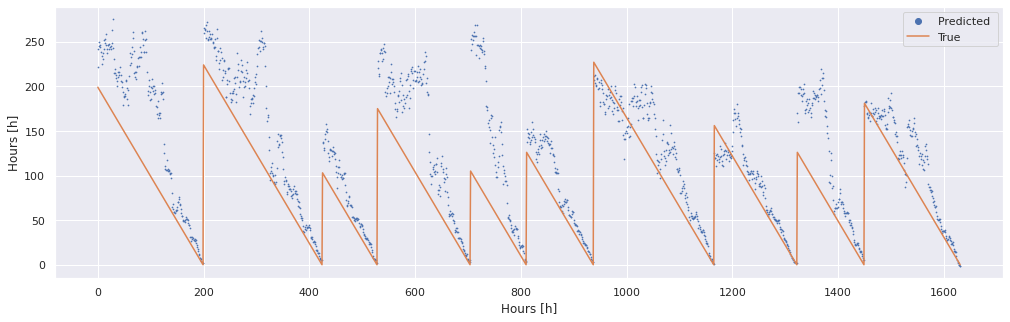

In [25]:
plot_predictions( 
    (
        true_values(val_iterator),
        model.predict(tf_regression_dataset(val_iterator).batch(32))
    ),
    figsize=(17, 5)
)

#### Test set results

47/47 [==============================] - 0s 9ms/step


<AxesSubplot:xlabel='Hours [h]', ylabel='Hours [h]'>

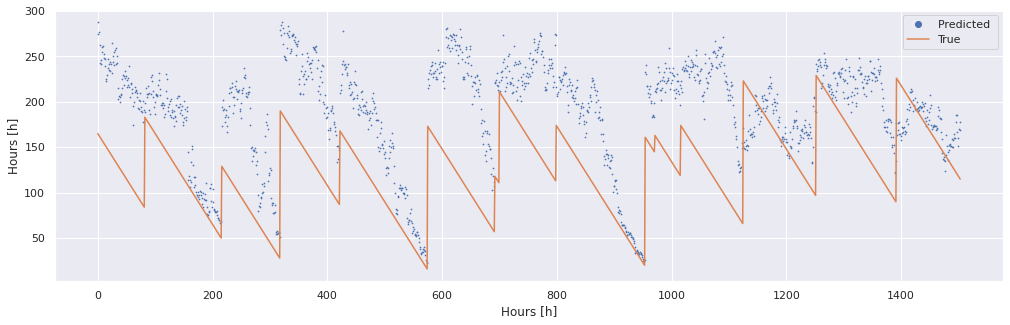

In [26]:
plot_predictions( 
    (
        true_values(test_iterator),
         model.predict(tf_regression_dataset(test_iterator).batch(32))
    ),
    figsize=(17, 5)
)

### Model Catalog

We have multiple keras models implemented. This models are just functions that return a uncompiled model. There are a few model published in literature ready to use.

In this case we are using the one proposed in 

Temporal Convolutional Memory Networks for Remaining Useful Life Estimation of Industrial Machinery
by Lahiru Jayasinghe, Tharaka Samarasinghe, Chau Yuen, Jenny Chen Ni Low, Shuzhi Sam Ge
    
[Reference](https://ieeexplore.ieee.org/abstract/document/8754956?casa_token=B_YvavFGulsAAAAA:f2k2I8pH1lM3sOcSGlXEF29seYPK1GPa9Od2-TwnhNeFyWvRRUAqkUOdWUNIyy9FPJHhsGM)

In [27]:
from ceruleo.models.keras.catalog.CNLSTM import CNLSTM

model = CNLSTM(
    train_iterator.shape,
    n_conv_layers=3,
    initial_convolutional_size=64,
    layers_recurrent=[32, 32],
    hidden_size=(10, 15),
    dense_layer_size=25,
    dropout=0.1,
)
model.summary()
model.compile(loss='mae', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              weighted_metrics=[])
model.fit(tf_regression_dataset(train_iterator).batch(32),
         validation_data=tf_regression_dataset(val_iterator).batch(32),
         epochs=25,
         callbacks=[EarlyStopping(patience=5)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 32, 64)            1856      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 64)           0         
 )                                                               
                                                                 
 conv1d_7 (Conv1D)           (None, 16, 128)           16512     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 8, 128)           0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 8, 256)            65792     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 4, 256)           0

51/51 [==============================] - 1s 10ms/step


<AxesSubplot:xlabel='Hours [h]', ylabel='Hours [h]'>

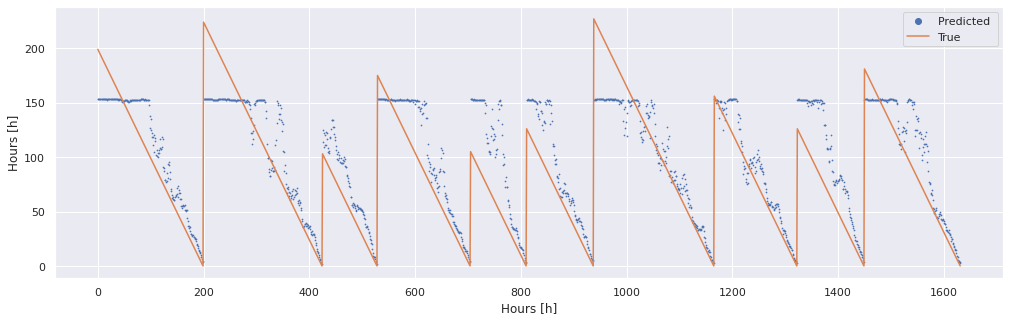

In [29]:
plot_predictions( 
    (
        true_values(val_iterator),
        model.predict(tf_regression_dataset(val_iterator).batch(32))
    ),
    figsize=(17, 5)
)

47/47 [==============================] - 0s 10ms/step


<AxesSubplot:xlabel='Hours [h]', ylabel='Hours [h]'>

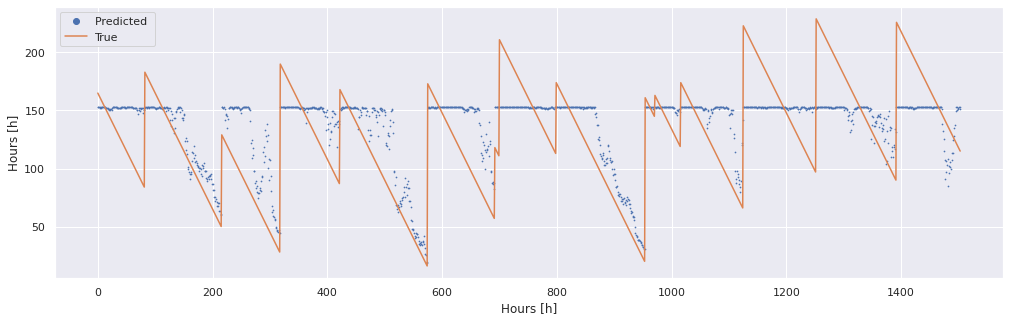

In [31]:
plot_predictions( 
    (
        true_values(test_iterator),
         model.predict(tf_regression_dataset(test_iterator).batch(32))
    ),
    figsize=(17, 5)
)

### Explainable model

#### XCM

[XCM: An Explainable Convolutional Neural Network for Multivariate Time Series Classification 
Kevin Fauvel, Tao Lin, Véronique Masson, Élisa Fromont and Alexandre Termier](https://arxiv.org/pdf/2009.04796.pdf)

"XCM allow the full exploitation of a faithful post hoc model-specific explainability method by identifying the observed variables and timestamps of the input data that are important for predictions"

XCM enables an identification of the regions of the input data that are important for predictions.

In [14]:
from ceruleo.models.keras.catalog.XCM import XCM, explain

In [25]:
model_XCM, model_extras = XCM( train_iterator.shape, n_filters=32, filter_window=3)
model_XCM.compile(
    jit_compile=True,
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    weighted_metrics=[])
model_XCM.fit(
    tf_regression_dataset(train_iterator).batch(32),
    validation_data=tf_regression_dataset(val_iterator).batch(32),
    epochs=25,
    callbacks=[EarlyStopping(patience=5)])

Epoch 1/25


2022-09-09 11:38:25.016636: I tensorflow/stream_executor/cuda/cuda_dnn.cc:5025] Disabling cuDNN frontend for the following convolution:
  input: {count: 32 feature_map_count: 1 spatial: 63 14  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 32 input_feature_map_count: 1 layout: OutputInputYX shape: 32 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity activation.


    492/Unknown - 8s 11ms/step - loss: 90.8212

2022-09-09 11:38:32.329728: I tensorflow/stream_executor/cuda/cuda_dnn.cc:5025] Disabling cuDNN frontend for the following convolution:
  input: {count: 31 feature_map_count: 1 spatial: 63 14  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 32 input_feature_map_count: 1 layout: OutputInputYX shape: 32 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity activation.


495/495 [==============================] - 11s 18ms/step - loss: 91.1590 - val_loss: 84.5694
Epoch 2/25


2022-09-09 11:38:34.641340: I tensorflow/stream_executor/cuda/cuda_dnn.cc:5025] Disabling cuDNN frontend for the following convolution:
  input: {count: 28 feature_map_count: 1 spatial: 63 14  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 32 input_feature_map_count: 1 layout: OutputInputYX shape: 32 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity activation.


495/495 [==============================] - 6s 12ms/step - loss: 83.6028 - val_loss: 75.1526
Epoch 3/25
495/495 [==============================] - 6s 12ms/step - loss: 68.7464 - val_loss: 58.8427
Epoch 4/25
495/495 [==============================] - 6s 12ms/step - loss: 48.8319 - val_loss: 38.0875
Epoch 5/25
495/495 [==============================] - 6s 12ms/step - loss: 32.0768 - val_loss: 24.3888
Epoch 6/25
495/495 [==============================] - 6s 12ms/step - loss: 25.8530 - val_loss: 20.6111
Epoch 7/25
495/495 [==============================] - 6s 13ms/step - loss: 24.1897 - val_loss: 19.9455
Epoch 8/25
495/495 [==============================] - 6s 12ms/step - loss: 23.7096 - val_loss: 24.6311
Epoch 9/25
495/495 [==============================] - 6s 13ms/step - loss: 23.2487 - val_loss: 22.9623
Epoch 10/25
495/495 [==============================] - 6s 12ms/step - loss: 22.9390 - val_loss: 20.5767
Epoch 11/25
495/495 [==============================] - 7s 13ms/step - loss: 22.7250

53/53 [==============================] - 1s 12ms/step


<AxesSubplot:xlabel='Hours [h]', ylabel='Hours [h]'>

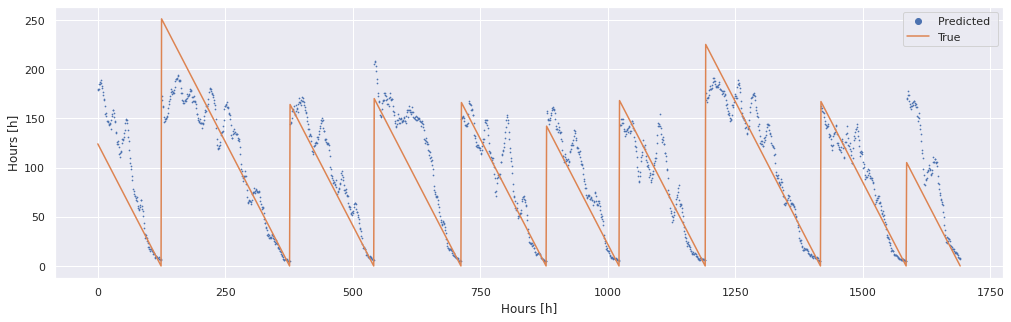

In [26]:
plot_predictions( 
    (
        true_values(val_iterator),
        model_XCM.predict(tf_regression_dataset(val_iterator).batch(32))
    ),
    figsize=(17, 5)
)


47/47 [==============================] - 0s 9ms/step


<AxesSubplot:xlabel='Hours [h]', ylabel='Hours [h]'>

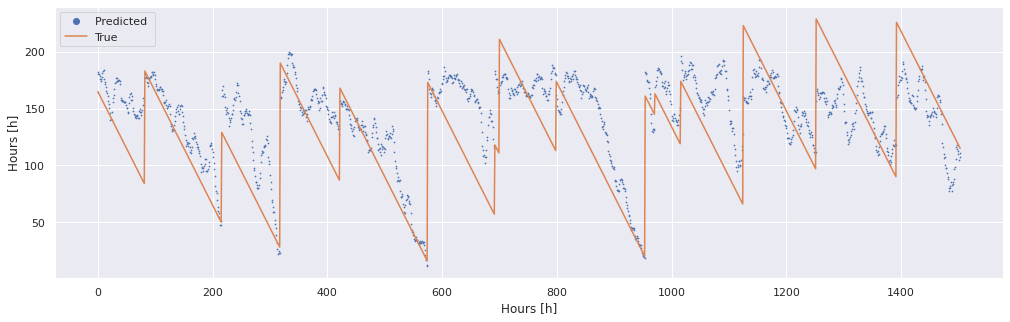

In [27]:
plot_predictions( 
    (
        true_values(test_iterator),
        model_XCM.predict(tf_regression_dataset(test_iterator).batch(32))
    ),
    figsize=(17, 5)
)


In [70]:
it = iter(val_iterator)
for i in range(45):
    X, y, sw = next(it)

In [71]:
mmap, v = explain(model_extras, X)

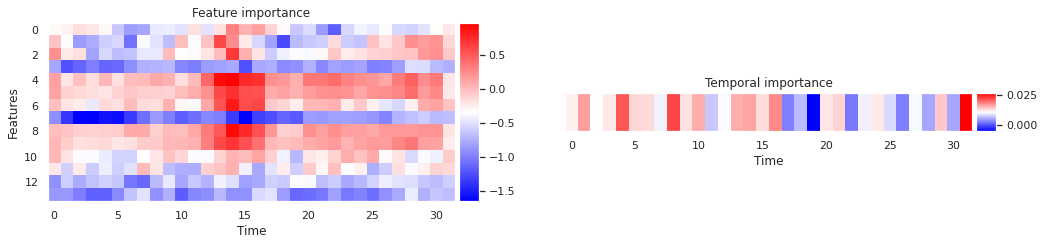

In [72]:
from ceruleo.graphics.explanations import XCM_explanation
XCM_explanation(mmap, v);

## LASSOLayer

[LASSOLAYER: NONLINEAR FEATURE SELECTION BY SWITCHING ONE-TO-ONE LINKS,
Akihito Sudo, Teng Teck Hou, Masaki Yamaguchi, Yoshinori Tone](https://arxiv.org/pdf/2108.12165.pdf)

LASSOLayer performs feature selection inside a depp learning architecture. We can use the same architecture we defien at the beggining of this guide but putting before the convolutional layers the LASSOLayer for performing feature selection

In [30]:

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (Conv1D, 
                                     SeparableConv1D, 
                                     GlobalMaxPooling1D,
                                     SpatialDropout1D,
                                     LayerNormalization,
                                     Dropout,
                                     Flatten, Dense, Lambda)
from ceruleo.models.keras.layers import LASSOLayer

input = Input(train_iterator.shape)
x = LASSOLayer(0.005)(input)
x = Conv1D(32, 3, padding='same', activation='relu')(x)
x = Conv1D(32, 3, padding='same', activation='relu')(x)
x = Conv1D(32, 3, padding='same', activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(32, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model(input, x)
model.compile(loss='mae', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              weighted_metrics=[])

In [31]:

model.fit(tf_regression_dataset(train_iterator).batch(32),
         validation_data=tf_regression_dataset(val_iterator).batch(32),
         epochs=25,
         callbacks=[EarlyStopping(patience=5)])

Epoch 1/25
492/492 [==============================] - 6s 12ms/step - loss: 78.5318 - Number of features: 284.2159 - val_loss: 41.2835 - val_Number of features: 188.0000
Epoch 2/25
492/492 [==============================] - 6s 12ms/step - loss: 38.8475 - Number of features: 168.5764 - val_loss: 38.0698 - val_Number of features: 155.0000
Epoch 3/25
492/492 [==============================] - 6s 12ms/step - loss: 36.6685 - Number of features: 145.1996 - val_loss: 36.1835 - val_Number of features: 135.0000
Epoch 4/25
492/492 [==============================] - 6s 12ms/step - loss: 35.5707 - Number of features: 132.4623 - val_loss: 35.2223 - val_Number of features: 132.0000
Epoch 5/25
492/492 [==============================] - 6s 12ms/step - loss: 35.1087 - Number of features: 130.2790 - val_loss: 33.9896 - val_Number of features: 130.0000
Epoch 6/25
492/492 [==============================] - 6s 13ms/step - loss: 34.6573 - Number of features: 130.0000 - val_loss: 33.3626 - val_Number of featu

58/58 [==============================] - 1s 9ms/step


<AxesSubplot:xlabel='Hours [h]', ylabel='Hours [h]'>

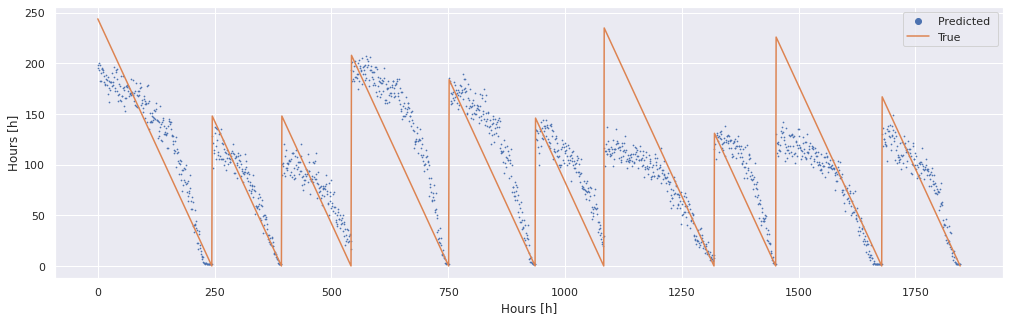

In [32]:
plot_predictions( 
    (
        true_values(val_iterator),
        model.predict(tf_regression_dataset(val_iterator).batch(32))
    ),
    figsize=(17, 5)
)


47/47 [==============================] - 0s 10ms/step


<AxesSubplot:xlabel='Hours [h]', ylabel='Hours [h]'>

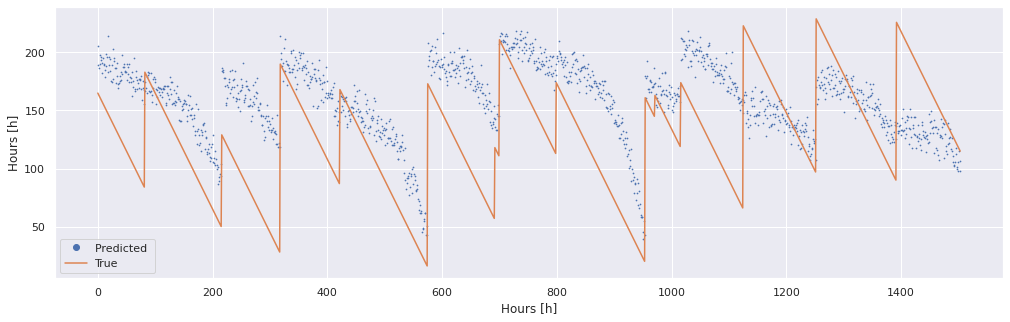

In [33]:
plot_predictions( 
    (
        true_values(test_iterator),
        model.predict(tf_regression_dataset(test_iterator).batch(32))
    ),
    figsize=(17, 5)
)


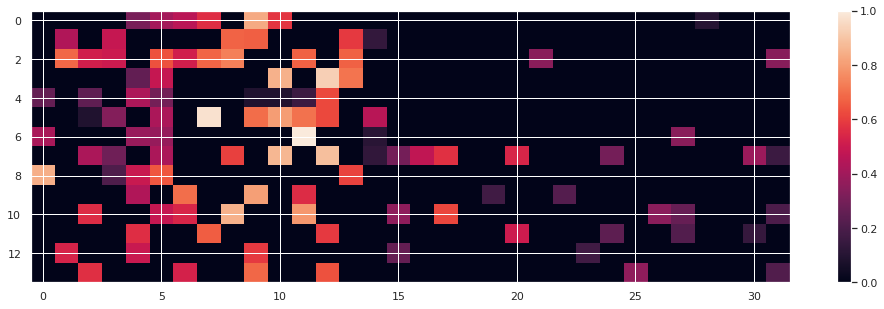

In [35]:
from ceruleo.graphics.explanations import show_LASSOLayer
show_LASSOLayer(model, test_iterator.shape, scale=True, figsize=(17, 5));